In [248]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

from tensorflow.keras import initializers, Model
from tensorflow.keras.layers import Dense, Layer, Conv2DTranspose, MaxPooling2D, Conv2D, GlobalAveragePooling2D, Reshape, BatchNormalization

import numpy as np
import matplotlib.pyplot as plt



import random
from tqdm import tqdm
import time 

# Whats open: #
1. ''' ADD PROPER DATA & Accuracy '''
2. Problem with input shape / Network architecture
2. Plotting of bottleneck

In [249]:
# Hyperparameters
VERBOSE = True
SHUFFLE_SIZE = 1000
BATCH_SIZE =128
PREFETCH_SIZE = 64
BUFFER_SIZE = 256

# Data

In [250]:
train_ds, test_ds = tfds.load('mnist', split=['train','test'], as_supervised=True)

### Show data

In [251]:
def add_noise(images, noise_factor = 0.1, noise_func = "normal"):
    if noise_func == "gaussian":
        sample_noise = keras.layers.GaussianNoise(noise_factor, dtype=tf.float32)
        noisy = sample_noise(images, training = True)
    elif noise_func == "normal":
        noisy = images + noise_factor * tf.random.normal(shape = images.shape)
        noisy = tf.clip_by_value(noisy, clip_value_min = 0., clip_value_max = 1.)
    return noisy

In [252]:
@tf.autograph.experimental.do_not_convert
def preprocess(data, noise_factor = 0.2, prepare = True):
    # Cast Image pixel values as floats
    data = data.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # Normalize pixel values
    data = data.map(lambda img, target: ((img/255), target))
    # Add noise to the data
    data = data.map(lambda img, target: (add_noise(img, noise_factor = noise_factor), img)) # image as normalized vector  
    # Shuffle, batch and prefetch
    if prepare: data = data.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(PREFETCH_SIZE)
    return data
    

2021-12-17 19:34:45.651579: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


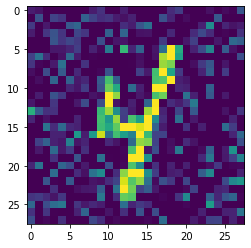

In [253]:
train_ds_image = preprocess(train_ds, noise_factor = 0.2, prepare = False)
train_ds_noisy = preprocess(train_ds)
test_ds_noisy = preprocess(test_ds)

#latent_space_data = preprocess(train_ds, prepare=False)

for image, label in train_ds_image.take(1):
  plt.imshow(image)
  

# Model

### Convolutional Autoencoder

In [254]:
class Encoder(Layer):
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv_1 = Conv2D(32, (3, 3), activation="relu", padding="same") # 32 layers of flitered 28x28 features
    self.pool_1 = MaxPooling2D((2, 2), padding="same") # 32 / 14 / 14 
    self.conv_2 = Conv2D(32, (3, 3), activation="relu", padding="same") # 32 / 14 / 14
    self.pool_2 = MaxPooling2D((2, 2), padding="same") # 32 / 7 / 7
    self.global_pooling = GlobalAveragePooling2D()
    self.dense = Dense(7, activation = "relu")


  @tf.function
  def call(self, input):
    x = self.conv_1(input)
    x = self.pool_1(x)
    x = self.conv_2(x)
    x = self.pool_1(x)
    x = self.global_pooling(x)
    x = self.dense(x)

    return (x)



In [255]:
class Decoder(Layer):
  def __init__(self):
    super(Decoder, self).__init__()
    # In Question
    self.dense = Dense(49, activation = "relu")
    # reshaoping layer to 7x7x1
    self.reshaping_layer = Reshape((7,7,1))
    self.transp_1 = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")
    self.batch_1 = BatchNormalization()
    self.transp_2 = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")
    self.batch_2 = BatchNormalization()
    self.conv_1 = Conv2D(1, (3, 3), activation="sigmoid", padding="same")

  @tf.function
  def call(self, input):
    x = self.dense(input)
    x = self.reshaping_layer(x)
    x = self.transp_1(x)
    x = self.batch_1(x)
    x = self.transp_2(x)
    x = self.batch_2(x)
    x = self.conv_1(x)

    return (x)



In [256]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()


    @tf.function
    def call(self, input):
        x = self.encoder(input)
        x = self.decoder(x)

        return x

     


class Autoencoder():


# Training

## Train step & test

In [257]:
# compute the loss of an input for the model and optimize/tweak according the parameters
def train_step(model, input, target, loss_function, optimizer):
    # use tf.gradientTape to compute loss, then gradients and apply these to the model to modify the parameters
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


# compute the differences between or model prediction and the label, -> Supervision
def test(model, test_data, loss_function):
  # test over complete test data
  test_loss_aggregator = []

  for (input, target) in test_data:

    prediction = model(input)
    
    sample_test_loss = loss_function(target, prediction)
    
    test_loss_aggregator.append(sample_test_loss.numpy())
    
# for all input and computed losses get the mean of accuracy and loss and return them
  test_loss = tf.reduce_mean(test_loss_aggregator)

  return test_loss

## Training

In [258]:
#predefine learning-rate and epochs
num_epochs = 10
alpha = 0.001

# create a model
model = Autoencoder()
model.summary
# define loss-function and optimizer
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# create empty arrays to store test/accuracy values, to track the network progress
train_losses = []
test_losses = []

# get initial accuracy- and loss valus before training starts
test_loss= test(model, test_ds_noisy, cross_entropy_loss)
test_losses.append(test_loss)

train_loss= test(model, train_ds_noisy, cross_entropy_loss)
train_losses.append(train_loss)

print("Starting Training AutoEncoder ")
# training loop
average_time = []
for epoch in range(num_epochs):
    # print accuracy of each epoch
    pre_train_time = time.time()
    
    loss_epoch = []
    # for all input, do a forwardstep and obtain loss
    for input, target in tqdm(train_ds_noisy):
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        loss_epoch.append(train_loss)
    # get the mean loss of this epoch by using reduce_sum of TF over all input-losses and appending to the array  
    train_losses.append(tf.reduce_mean(loss_epoch))
    
    # get the losses and accuracy of this epoch and store them
    test_loss = test(model, test_ds_noisy, cross_entropy_loss)
    test_losses.append(test_loss)

    average_time.append(time.time() - pre_train_time)
    print("Took: " + str(time.time() - pre_train_time))
    print("Loss for this epoch: " + str(test_loss))
    
# print accuracy after 10 epochs
print("Mean Time per Epoch: " + str(round(np.mean(average_time), 2)) + "! With Parameters: ")

print("Batch size: " + str(BATCH_SIZE) + "  Prefetch size: " + str(PREFETCH_SIZE) + "  Buffer size: " + str(BUFFER_SIZE))


2021-12-17 19:34:46.016210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-17 19:34:47.261890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-17 19:34:53.234670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Starting Training AutoEncoder 


  0%|          | 0/469 [00:00<?, ?it/s]2021-12-17 19:34:53.510124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-17 19:34:53.573116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
100%|█████████▉| 467/469 [00:14<00:00, 33.77it/s]2021-12-17 19:35:08.050806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-17 19:35:08.100434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
100%|██████████| 469/469 [00:14<00:00, 31.54it/s]


Took: 15.918913125991821
Loss for this epoch: tf.Tensor(0.28262958, shape=(), dtype=float32)


100%|██████████| 469/469 [00:14<00:00, 31.88it/s]


Took: 16.05369210243225
Loss for this epoch: tf.Tensor(0.2546183, shape=(), dtype=float32)


100%|██████████| 469/469 [00:15<00:00, 30.60it/s]


Took: 16.4409282207489
Loss for this epoch: tf.Tensor(0.2517838, shape=(), dtype=float32)


100%|██████████| 469/469 [00:15<00:00, 31.11it/s]


Took: 16.149335145950317
Loss for this epoch: tf.Tensor(0.25040346, shape=(), dtype=float32)


100%|██████████| 469/469 [00:14<00:00, 32.46it/s]


Took: 15.569478988647461
Loss for this epoch: tf.Tensor(0.24929202, shape=(), dtype=float32)


100%|██████████| 469/469 [00:14<00:00, 32.84it/s]


Took: 15.31685495376587
Loss for this epoch: tf.Tensor(0.24870723, shape=(), dtype=float32)


100%|██████████| 469/469 [00:14<00:00, 33.11it/s]


Took: 15.210165023803711
Loss for this epoch: tf.Tensor(0.24904343, shape=(), dtype=float32)


100%|██████████| 469/469 [00:14<00:00, 33.48it/s]


Took: 15.043965816497803
Loss for this epoch: tf.Tensor(0.24750848, shape=(), dtype=float32)


100%|██████████| 469/469 [00:14<00:00, 33.00it/s]


Took: 15.245007038116455
Loss for this epoch: tf.Tensor(0.24687794, shape=(), dtype=float32)


100%|██████████| 469/469 [00:14<00:00, 33.36it/s]


Took: 15.097979068756104
Loss for this epoch: tf.Tensor(0.24532232, shape=(), dtype=float32)
Mean Time per Epoch: 15.6! With Parameters: 
Batch size: 128  Prefetch size: 64  Buffer size: 256


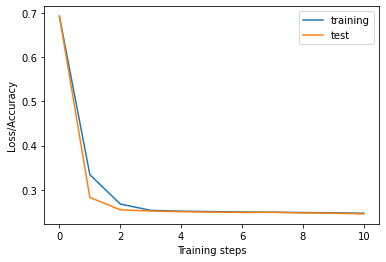

In [259]:
# Visualisation
import matplotlib.pyplot as plt

plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2),("training","test"))
plt.show()

# Latent Space Analysis


In [260]:
from sklearn.manifold import TSNE
latent_vars = []

for noisy_image, image in train_ds_noisy.take(10):
    latent_vars.append(model.encoder(noisy_image))
print(latent_vars)
latent_vars_array = np.array(latent_vars)
latent_vars_array_flattened = latent_vars_array.reshape(1280,7)
print(latent_vars_array_flattened.shape)

latent_vars_2D = TSNE(n_components=2).fit_transform(latent_vars_array_flattened)
print(latent_vars_2D.shape)
print(latent_vars_2D)


2021-12-17 19:37:29.497792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/usr/local/Caskroom/miniforge/base/envs/ann/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ann/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[<tf.Tensor: shape=(128, 7), dtype=float32, numpy=
array([[ 8.444237 , 17.99133  ,  8.655952 ,  0.       ,  0.       ,
         0.       ,  0.       ],
       [ 9.730499 , 18.64572  ,  8.081327 ,  0.       ,  0.       ,
         0.       ,  0.       ],
       [ 8.4815035, 17.642138 ,  8.55609  ,  0.       ,  0.       ,
         0.       ,  0.       ],
       [ 6.6975274, 15.9646435,  9.423097 ,  0.       ,  0.       ,
         0.       ,  0.       ],
       [ 5.5157094, 15.15432  , 10.265952 ,  0.       ,  0.       ,
         0.       ,  0.       ],
       [ 6.9898086, 16.406643 ,  9.204094 ,  0.       ,  0.       ,
         0.       ,  0.       ],
       [ 7.221466 , 16.066195 ,  8.978472 ,  0.       ,  0.       ,
         0.       ,  0.       ],
       [ 5.9452634, 15.360285 ,  9.867113 ,  0.       ,  0.       ,
         0.       ,  0.       ],
       [ 8.186339 , 17.80085  ,  8.865793 ,  0.       ,  0.       ,
         0.       ,  0.       ],
       [ 5.991082 , 15.465258 ,  9.81686

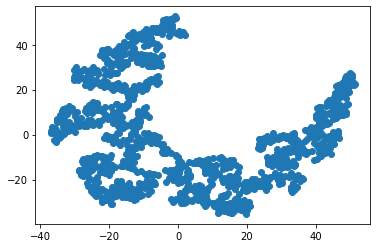

In [261]:
X = []
Y = []
for x,y in latent_vars_2D:
    X.append(x)
    Y.append(y)

plt.scatter(X,Y)
plt.show()

